In [2]:
! rm -rf space-model
! git clone https://github.com/StepanTita/space-model.git

Cloning into 'space-model'...
remote: Enumerating objects: 155, done.
remote: Counting objects: 100% (155/155), done.
remote: Compressing objects: 100% (129/129), done.
remote: Total 155 (delta 47), reused 128 (delta 23), pack-reused 0
Receiving objects: 100% (155/155), 29.68 MiB | 26.11 MiB/s, done.
Resolving deltas: 100% (47/47), done.


In [1]:
! pip install adapters

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 263.0/263.0 KB 9.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.0/9.0 MB 8.5 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: transformers
    Found existing installation: transformers 4.40.0
    Uninstalling transformers-4.40.0:
      Successfully uninstalled transformers-4.40.0
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
autotrain-advanced 0.7.63 requires protobuf==4.23.4, but you have protobuf 3.20.0 which is incompatible.
autotrain-advanced 0.7.63 requires transformers==4.40.0, but you have transformers 4.40.2 which is incompatible.


In [9]:
import pandas as pd

import torch

from sklearn.model_selection import train_test_split

from datasets import load_dataset, Dataset, DatasetDict

from adapters import AutoAdapterModel
from transformers import AutoModel, AutoTokenizer, AutoModelForSequenceClassification

from train import run, get_preds_from_logits, prepare_dataset, init_space, count_parameters

from collections import Counter

In [3]:
# MODEL_NAME = 'distilbert-base-cased'
DATASET_NAME = 'hatespeech'

SEED = 42
NUM_EPOCHS = 15
BATCH_SIZE = 256
MAX_SEQ_LEN = 512
LEARNING_RATE = 2e-5
MAX_GRAD_NORM = 1000

In [4]:
def prepare_hateoffensive(model_name, max_seq_len, device, seed):
    # 3 classes
    dataset = load_dataset("tdavidson/hate_speech_offensive")

    # Split the training set into training (80%) and validation (20%) sets
    train_testvalid = dataset['train'].train_test_split(test_size=0.2, seed=42)
    test_valid = train_testvalid['test'].train_test_split(test_size=0.5, seed=42)

    # Assign datasets
    train_dataset = train_testvalid['train']
    val_dataset = test_valid['test']
    test_dataset = test_valid['train']

    dataset = DatasetDict({
        'train': train_dataset,
        'test': test_dataset,
        'val': val_dataset
    })

    tokenizer = AutoTokenizer.from_pretrained(model_name)
    tokenized_dataset = dataset.map(
        lambda x: tokenizer(x['tweet'], truncation=True, padding='max_length', max_length=max_seq_len,
                            return_tensors='pt'),
        batched=True)
    tokenized_dataset.set_format('torch', device=device)

    return tokenized_dataset.rename_columns({'class': 'label'})

def prepare_hatexplain(model_name, max_seq_len, device, seed):
    # 3 classes
    def get_label(annotators):
        # get the most common label using simple voting and accounting for batching
        return [Counter(anno['label']).most_common(1)[0][0] for anno in annotators]
            
    dataset = load_dataset('hatexplain')
    dataset = dataset.map(lambda x: {'label': get_label(x['annotators'])}, num_proc=4, batched=True)
    dataset['val'] = dataset['validation']
    del dataset['validation']
    
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    
    tokenized_dataset = dataset.map(lambda x: tokenizer(x['post_tokens'], truncation=True, padding='max_length', max_length=max_seq_len, return_tensors='pt'), batched=True)
    tokenized_dataset.set_format('torch', device=device)
    
    return tokenized_dataset

def prepare_emotions(model_name, max_seq_len, device, seed):
    # 28 classes
    emotions_1_df = pd.read_csv(f'data/goemotions_1.csv')
    emotions_2_df = pd.read_csv(f'data/goemotions_2.csv')
    emotions_3_df = pd.read_csv(f'data/goemotions_3.csv')

    emotions_df = pd.concat([
        emotions_1_df,
        emotions_2_df,
        emotions_3_df
    ], ignore_index=True, axis=0)
    
    labels = [
        'admiration',
        'amusement',
        'anger',
        'annoyance',
        'approval',
        'caring',
        'confusion',
        'curiosity',
        'desire',
        'disappointment',
        'disapproval',
        'disgust',
        'embarrassment',
        'excitement',
        'fear',
        'gratitude',
        'grief',
        'joy',
        'love',
        'nervousness',
        'optimism',
        'pride',
        'realization',
        'relief',
        'remorse',
        'sadness',
        'surprise',
        'neutral'
    ]
    emotions_df['label'] = emotions_df[labels].apply(lambda x: x.to_list(), axis=1)
    
    train_split, test_split = train_test_split(emotions_df, test_size=0.2, random_state=seed)
    test_split, val_split = train_test_split(test_split, test_size=0.5, random_state=seed)
    dataset = DatasetDict({
        'train': Dataset.from_pandas(train_split[['text', 'label']]),
        'val': Dataset.from_pandas(test_split[['text', 'label']]),
        'test': Dataset.from_pandas(val_split[['text', 'label']]),
    })
    
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    
    tokenized_dataset = dataset
    tokenized_dataset = tokenized_dataset.map(
        lambda x: tokenizer(x['text'], truncation=True, padding='max_length', max_length=MAX_SEQ_LEN,
                            return_tensors='pt'), batched=True)
    tokenized_dataset.set_format('torch', device=device)
    return tokenized_dataset

def prepare_fake(model_name, max_seq_len, device, seed):
    train_df = pd.read_csv('data/fake_train.csv', index_col=0)
    train_df['final'] = 'Title: ' + train_df['title'] + ' Text: ' + train_df['text']
    
    train_df = train_df[train_df['title'].notnull() & train_df['text'].notnull()]
    
    test_df = pd.read_csv('data/fake_test.csv', index_col=0)
    test_df['final'] = 'Title: ' + test_df['title'] + ' Text: ' + test_df['text']
    
    train_split, test_split = train_test_split(train_df, test_size=0.2, random_state=seed)
    test_split, val_split = train_test_split(test_split, test_size=0.5, random_state=seed)
    
    dataset = DatasetDict({
        'train': Dataset.from_pandas(train_split[['final', 'label']]),
        'test': Dataset.from_pandas(test_split[['final', 'label']]),
        'val': Dataset.from_pandas(val_split[['final', 'label']])
    })
    
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    
    tokenized_dataset = dataset.map(lambda x: tokenizer(x['final'], truncation=True, padding=True, max_length=MAX_SEQ_LEN, return_tensors='pt'), batched=True)
    tokenized_dataset.set_format('torch', device=device)
    
    return tokenized_dataset

In [5]:
class ModelOutput:
    def __init__(self, loss, logits):
        self.loss = loss
        self.logits = logits

In [6]:
class ModelForSequenceClassification(torch.nn.Module):
    
    def __init__(self, base_model_name, n_embed, num_labels):
        super(ModelForSequenceClassification, self).__init__()
        self.base_model = AutoModel.from_pretrained(base_model_name, num_labels=num_labels)
        
        self.embedding_dim = self.base_model.config.hidden_size
        self.additional_layer = torch.nn.Linear(self.embedding_dim, n_embed)
        self.classifier = torch.nn.Linear(n_embed, num_labels)
        self.loss_fn = torch.nn.CrossEntropyLoss()
        
    def to(self, device):
        self.device = device
        super().to(device)
        return self
        
    def forward(self, input_ids, attention_mask=None, token_type_ids=None, labels=None):
        # Get outputs from the base model
        outputs = self.base_model(input_ids=input_ids, 
                                  attention_mask=attention_mask, 
                                  token_type_ids=token_type_ids)
        
        # Get the hidden states of the last layer
        hidden_states = outputs.last_hidden_state
        
        # Apply pooling - mean pooling here for simplicity
        pooled_output = hidden_states.mean(dim=1)
        
        # Pass through the additional layer
        embed_output = self.additional_layer(pooled_output)
        embed_output = torch.relu(embed_output)
        
        # Classifier layer
        logits = self.classifier(embed_output)
        
        loss = None
        if labels is not None:
            loss = self.loss_fn(logits, labels)
        
        return ModelOutput(loss, logits)

In [7]:
def init_base(config):
    model = ModelForSequenceClassification(config["model_name"], n_embed=768, num_labels=config['num_labels'])

    for param in model.base_model.parameters():
        param.requires_grad = False
    return model

In [10]:
model = AutoAdapterModel.from_pretrained("FacebookAI/roberta-base")

adapter_name = model.load_adapter("AdapterHub/roberta-base-pf-imdb")

model.active_adapters = adapter_name
model

Some weights of RobertaAdapterModel were not initialized from the model checkpoint at FacebookAI/roberta-base and are newly initialized: ['heads.default.3.bias', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Fetching 6 files:   0%|          | 0/6 [00:00<?, ?it/s]

.gitattributes:   0%|          | 0.00/1.18k [00:00<?, ?B/s]

adapter_config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/2.25k [00:00<?, ?B/s]

head_config.json:   0%|          | 0.00/368 [00:00<?, ?B/s]

pytorch_model_head.bin:   0%|          | 0.00/2.37M [00:00<?, ?B/s]

pytorch_adapter.bin:   0%|          | 0.00/3.59M [00:00<?, ?B/s]

RobertaAdapterModel(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttentionWithAdapters(
              (query): LoRALinearTorch(
                in_features=768, out_features=768, bias=True
                (loras): ModuleDict()
              )
              (key): LoRALinearTorch(
                in_features=768, out_features=768, bias=True
                (loras): ModuleDict()
              )
              (value): LoRALinearTorch(
                in_features=768, out_features=768, bias=True
                (

In [7]:
def train_wrapper(device_id, train_base, train_space, experiment_name, n_latent, config):
    def train():
        run({
            'experiment_name': experiment_name,
            
            'log_terminal': True,

            'device_id': device_id,
            'train_base': train_base,
            'train_space': train_space,

            'seed': SEED,
            'dataset_name': config['dataset_name'],
            'model_name': config['model_name'],

            'num_labels': config['num_labels'],
            'num_epochs': NUM_EPOCHS,
            'iterations': 1,

            'max_seq_len': MAX_SEQ_LEN,
            'batch_size': BATCH_SIZE,
            'lr': LEARNING_RATE,
            'fp16': False,
            'max_grad_norm': MAX_GRAD_NORM,
            'weight_decay': 0.01,
            'num_warmup_steps': 0,
            'gradient_accumulation_steps': 1,

            'n_latent': n_latent,
            'l1': config['l1'],
            'l2': config['l2'],
            'cross_entropy_weight': config['ce_w'],
            
            # funcs:
            'preds_from_logits_func': get_preds_from_logits,
            'get_data_func': config['prepare_dataset'],
            'init_space_func': init_space,
            'init_base_func': init_base
        })

    return train

In [8]:
count_parameters(init_space({
    'model_name': 'bert-base-cased',
    'num_labels': 2,
    'n_latent': 300,
    'l1': 0,
    'l2': 0,
    'cross_entropy_weight': 0
}
))

462002

Starting...
Config: {'experiment_name': 'dense', 'log_terminal': True, 'device_id': 1, 'train_base': False, 'train_space': True, 'seed': 42, 'dataset_name': 'hatespeech', 'model_name': 'bert-base-cased', 'num_labels': 3, 'num_epochs': 15, 'iterations': 1, 'max_seq_len': 512, 'batch_size': 256, 'lr': 2e-05, 'fp16': False, 'max_grad_norm': 1000, 'weight_decay': 0.01, 'num_warmup_steps': 0, 'gradient_accumulation_steps': 1, 'n_latent': 255, 'l1': 0.001, 'l2': 1e-07, 'cross_entropy_weight': 1.0, 'preds_from_logits_func': <function get_preds_from_logits at 0x71eb97498a60>, 'get_data_func': <function prepare_hateoffensive at 0x71eb97497820>, 'init_space_func': <function init_space at 0x71eb97497040>, 'init_base_func': <function init_base at 0x71eb974a1b80>}
Loading dataset...
Training space model...
Number of space model parameters: 589818
Inter-space loss: 0.2577876150608063
Intra-space loss: 2.1032333374023438
****************************** Iteration: 1 ******************************
Train

Initial GPU Usage
GPU memory occupied: 10683 MB.
GPU Usage after emptying the cache
GPU memory occupied: 1075 MB.


Evaluating space model on test set:
100%|███████████████████████████████████████████| 10/10 [00:25<00:00,  2.55s/it]
/home/stepan/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Val loss: 0.5038563787937165
Val acc: 0.8240516545601292
CS Val acc: 0.12389023405972559
Val f1: 0.4543183030815539
CS Val f1: 0.1364698279471749
Val precision: 0.5677515255828509
Val recall: 0.4359122701705777


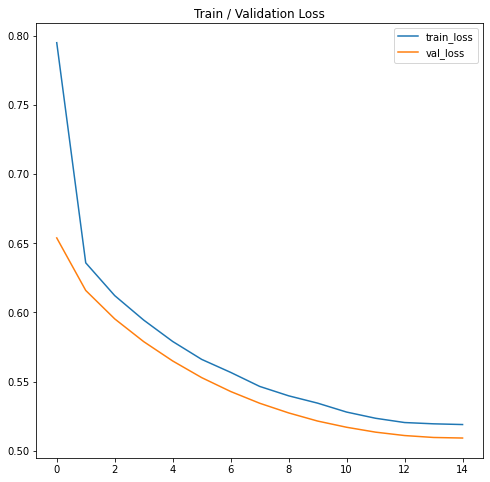

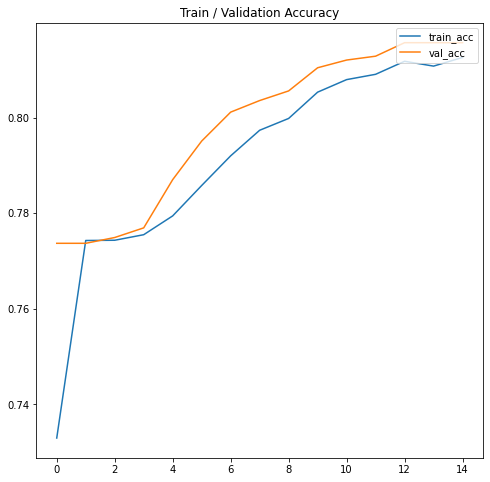

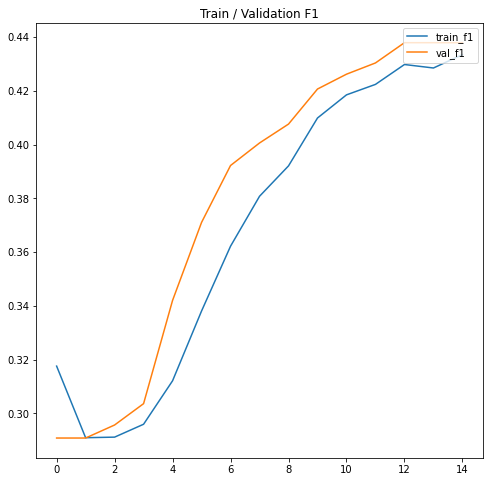

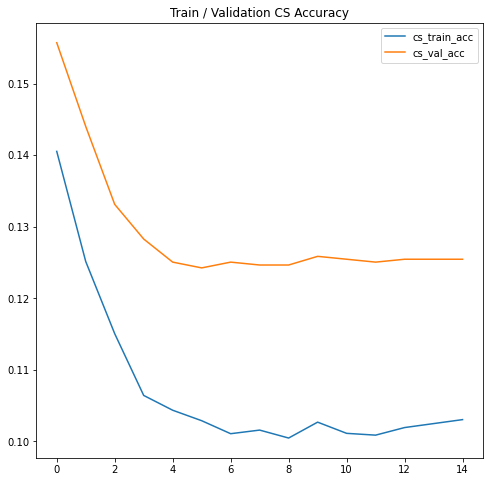

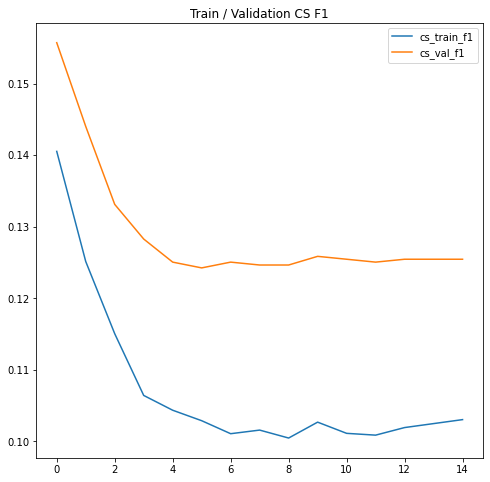

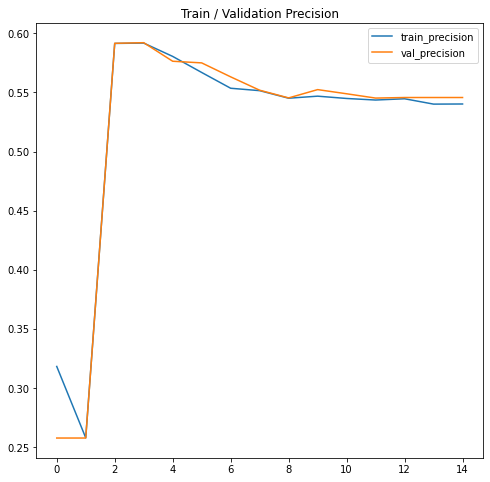

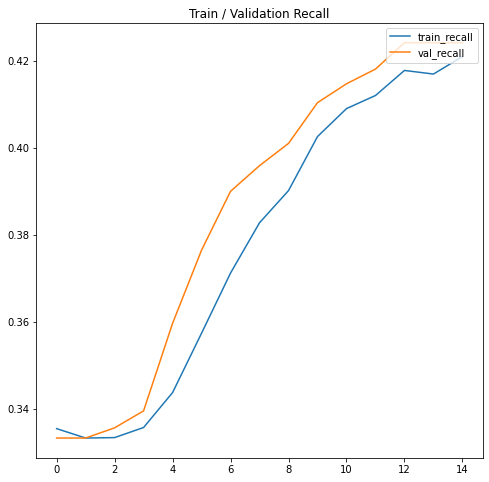

In [11]:
train_wrapper(device_id=1, train_base=False, train_space=True, experiment_name='dense', n_latent=255, config={
    'l1': 0.001,
    'l2': 1e-7,
    'ce_w': 1.0,
    'model_name': 'bert-base-cased',
    'dataset_name': 'hatespeech',
    'prepare_dataset': prepare_hateoffensive,
    'num_labels': 3,
})()

Starting...
Config: {'experiment_name': 'dense', 'log_terminal': True, 'device_id': 1, 'train_base': False, 'train_space': True, 'seed': 42, 'dataset_name': 'fake', 'model_name': 'bert-base-cased', 'num_labels': 2, 'num_epochs': 15, 'iterations': 1, 'max_seq_len': 512, 'batch_size': 256, 'lr': 2e-05, 'fp16': False, 'max_grad_norm': 1000, 'weight_decay': 0.01, 'num_warmup_steps': 0, 'gradient_accumulation_steps': 1, 'n_latent': 300, 'l1': 0.001, 'l2': 1e-07, 'cross_entropy_weight': 1.0, 'preds_from_logits_func': <function get_preds_from_logits at 0x71eb97498a60>, 'get_data_func': <function prepare_fake at 0x71eb97497af0>, 'init_space_func': <function init_space at 0x71eb97497040>, 'init_base_func': <function init_base at 0x71eb974a1b80>}
Loading dataset...


Map:   0%|          | 0/16162 [00:00<?, ? examples/s]

Map:   0%|          | 0/2020 [00:00<?, ? examples/s]

Map:   0%|          | 0/2021 [00:00<?, ? examples/s]

Training space model...
Number of space model parameters: 462002
Inter-space loss: 0.2562920153141022
Intra-space loss: 0.3194110095500946
****************************** Iteration: 1 ******************************
Train steps: 946
Steps per epoch: 63.1328125
Epoch: 1
100%|█████████████████████████████████████████████| 8/8 [00:21<00:00,  2.63s/it]

Train loss: 0.6620169095695019 | Val loss: 0.6298394426703453
Train acc: 0.6366167553520604 | Val acc: 0.7159821870361207
CS Train acc: 0.501608711793095 | CS Val acc: 0.4987629886194953
Train f1: 0.587659095556208 | Val f1: 0.7015105948514004
CS Train f1: 0.477655137825292 | CS Val f1: 0.4776838482449124
Train precision: 0.72752421072054 | Val precision: 0.7536608235199644
Train recall: 0.6278165913810263 | Val recall: 0.7105161541974647
Epoch: 2
100%|█████████████████████████████████████████████| 8/8 [00:21<00:00,  2.63s/it]

Train loss: 0.6071650143712759 | Val loss: 0.581835187971592
Train acc: 0.7205172627150105 | Val acc: 0.761999010390

Initial GPU Usage
GPU memory occupied: 10681 MB.
GPU Usage after emptying the cache
GPU memory occupied: 1071 MB.


Evaluating space model on test set:
100%|█████████████████████████████████████████████| 8/8 [00:21<00:00,  2.63s/it]
Val loss: 0.3850911445915699
Val acc: 0.8608910891089109
CS Val acc: 0.6163366336633663
Val f1: 0.859047801622979
CS Val f1: 0.6057508249516035
Val precision: 0.8701727642276422
Val recall: 0.8576622195776002


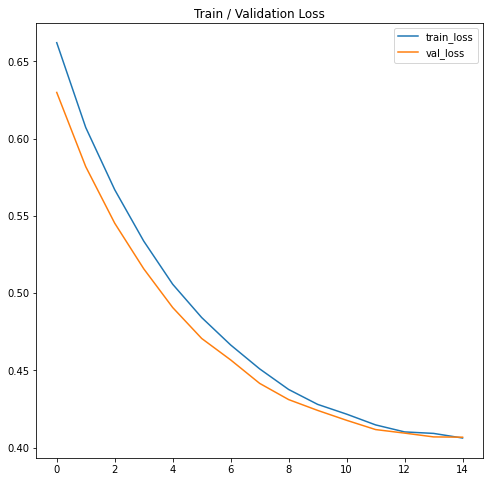

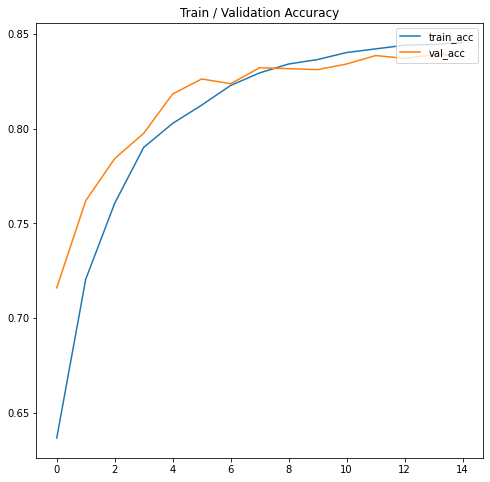

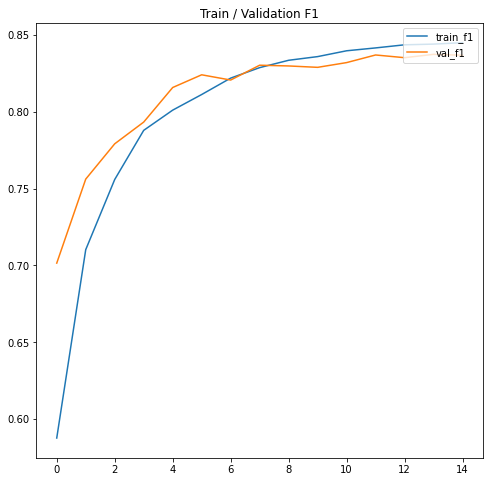

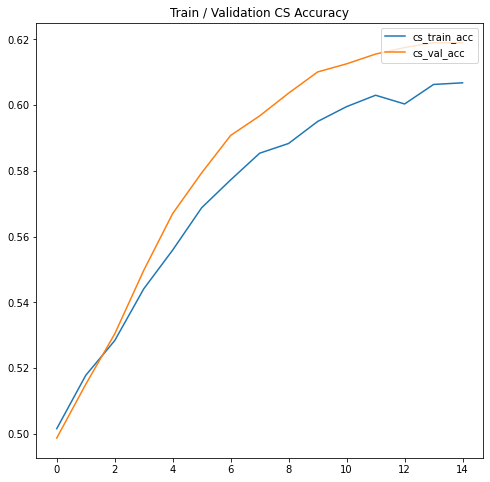

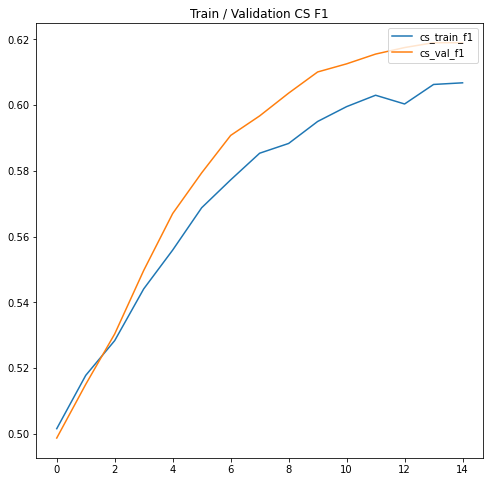

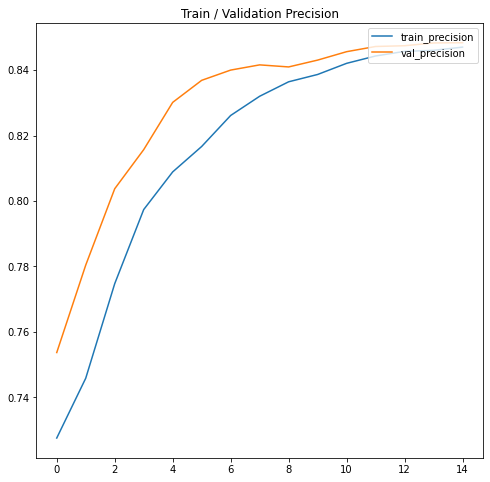

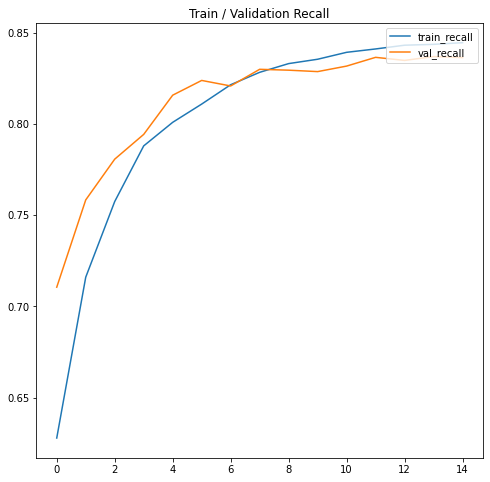

In [12]:
train_wrapper(device_id=1, train_base=False, train_space=True, experiment_name='dense', n_latent=300, config={
    'l1': 0.001,
    'l2': 1e-7,
    'ce_w': 1.0,
    'model_name': 'bert-base-cased',
    'dataset_name': 'fake',
    'prepare_dataset': prepare_fake,
    'num_labels': 2,
})()

Starting...
Config: {'experiment_name': 'dense', 'log_terminal': True, 'device_id': 1, 'train_base': False, 'train_space': True, 'seed': 42, 'dataset_name': 'imdb', 'model_name': 'bert-base-cased', 'num_labels': 2, 'num_epochs': 15, 'iterations': 1, 'max_seq_len': 512, 'batch_size': 256, 'lr': 2e-05, 'fp16': False, 'max_grad_norm': 1000, 'weight_decay': 0.01, 'num_warmup_steps': 0, 'gradient_accumulation_steps': 1, 'n_latent': 300, 'l1': 0.001, 'l2': 1e-07, 'cross_entropy_weight': 1.0, 'preds_from_logits_func': <function get_preds_from_logits at 0x71eb97498a60>, 'get_data_func': <function prepare_dataset at 0x71eb97498670>, 'init_space_func': <function init_space at 0x71eb97497040>, 'init_base_func': <function init_base at 0x71eb974a1b80>}
Loading dataset...
Training space model...
Number of space model parameters: 462002
Inter-space loss: 0.25677070021629333
Intra-space loss: 0.359510600566864
****************************** Iteration: 1 ******************************
Train steps: 1171

Initial GPU Usage
GPU memory occupied: 10681 MB.
GPU Usage after emptying the cache
GPU memory occupied: 1071 MB.


Evaluating space model on test set:
100%|███████████████████████████████████████████| 98/98 [04:16<00:00,  2.62s/it]
Val loss: 0.414843705843906
Val acc: 0.83268
CS Val acc: 0.71896
Val f1: 0.832675544885988
CS Val f1: 0.7186805061571444
Val precision: 0.8327154349923438
Val recall: 0.8326800000000001


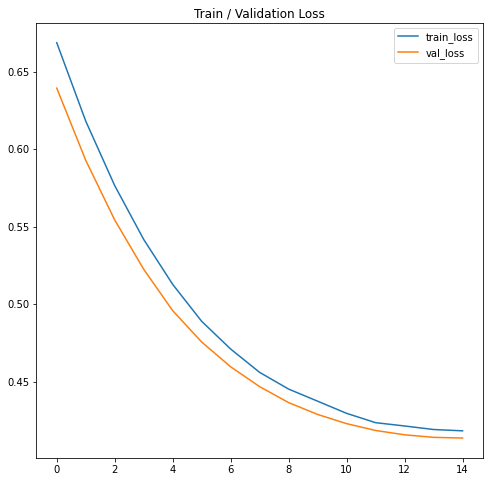

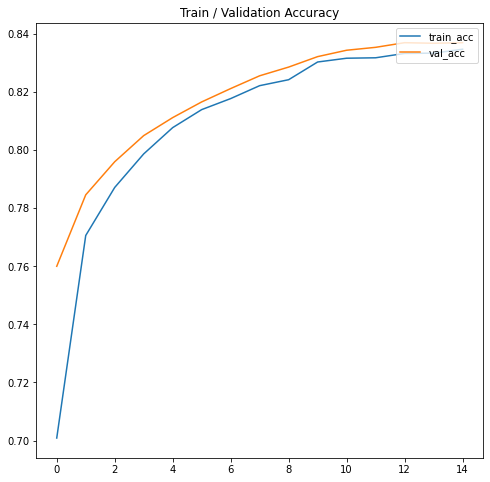

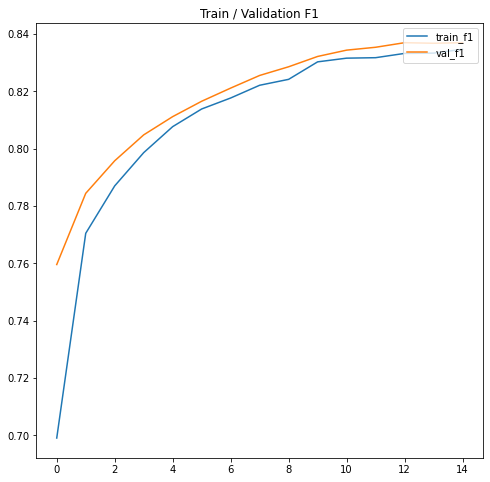

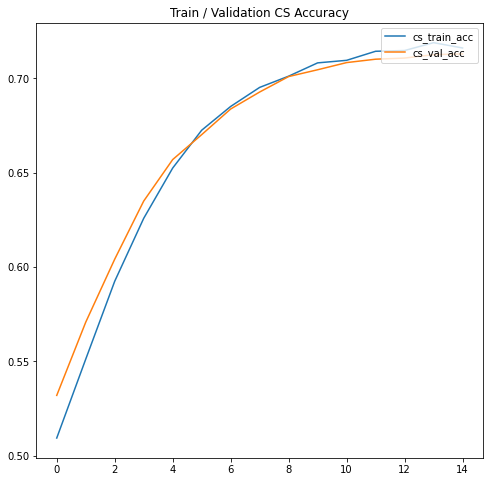

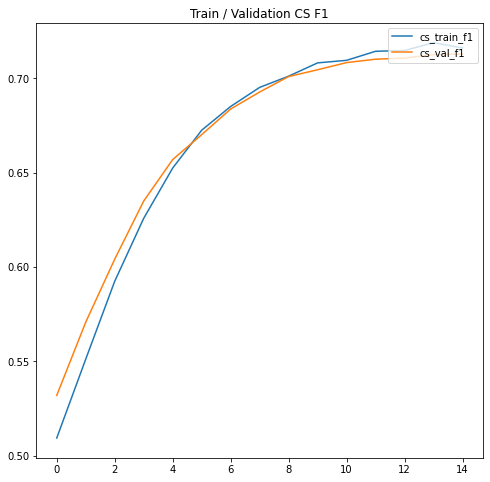

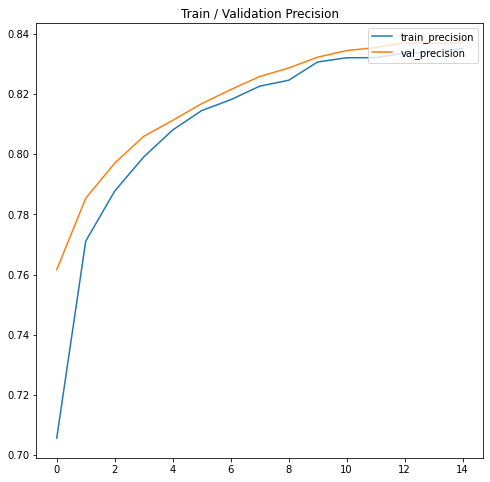

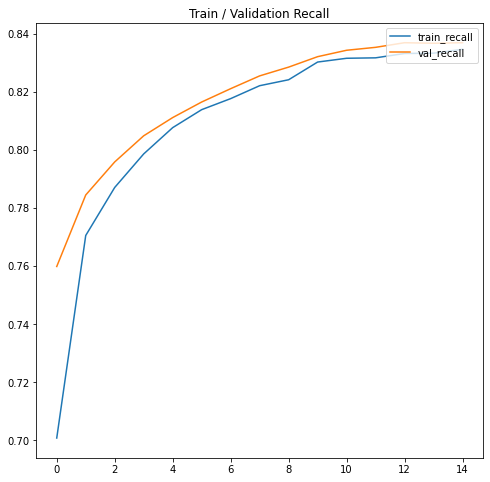

In [13]:
train_wrapper(device_id=1, train_base=False, train_space=True, experiment_name='dense', n_latent=300, config={
    'l1': 0.001,
    'l2': 1e-7,
    'ce_w': 1.0,
    'model_name': 'bert-base-cased',
    'dataset_name': 'imdb',
    'prepare_dataset': prepare_dataset,
    'num_labels': 2,
})()

Starting...
Config: {'experiment_name': 'dense', 'log_terminal': True, 'device_id': 1, 'train_base': False, 'train_space': True, 'seed': 42, 'dataset_name': 'imdb', 'model_name': 'FacebookAI/roberta-base', 'num_labels': 2, 'num_epochs': 15, 'iterations': 1, 'max_seq_len': 512, 'batch_size': 256, 'lr': 2e-05, 'fp16': False, 'max_grad_norm': 1000, 'weight_decay': 0.01, 'num_warmup_steps': 0, 'gradient_accumulation_steps': 1, 'n_latent': 250, 'l1': 0.001, 'l2': 1e-07, 'cross_entropy_weight': 1.0, 'preds_from_logits_func': <function get_preds_from_logits at 0x71eb97498a60>, 'get_data_func': <function prepare_dataset at 0x71eb97498670>, 'init_space_func': <function init_space at 0x71eb97497040>, 'init_base_func': <function init_base at 0x71eb974a1b80>}
Loading dataset...
Training space model...
Some weights of RobertaModel were not initialized from the model checkpoint at FacebookAI/roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You shou

Initial GPU Usage
GPU memory occupied: 11445 MB.
GPU Usage after emptying the cache
GPU memory occupied: 1457 MB.


Evaluating space model on test set:
100%|███████████████████████████████████████████| 98/98 [04:07<00:00,  2.52s/it]
Val loss: 0.4984109921722996
Val acc: 0.83244
CS Val acc: 0.23712
Val f1: 0.8324280632476861
CS Val f1: 0.22016757094190234
Val precision: 0.8325347505896383
Val recall: 0.83244


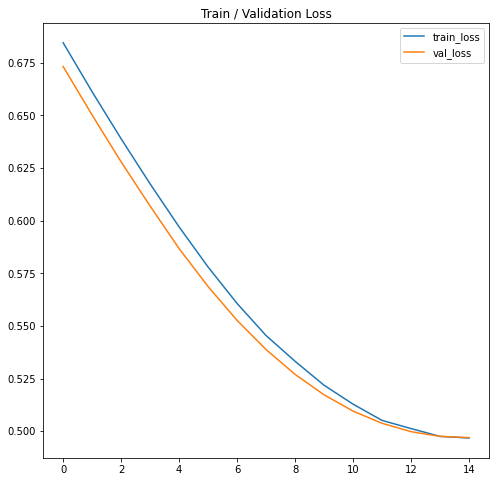

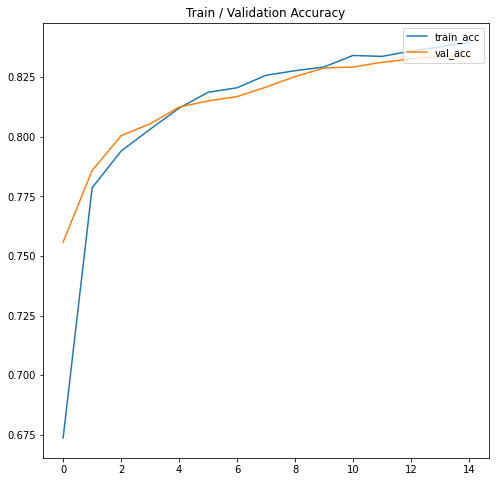

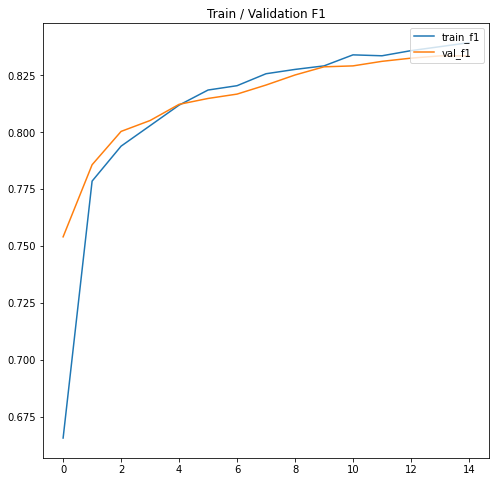

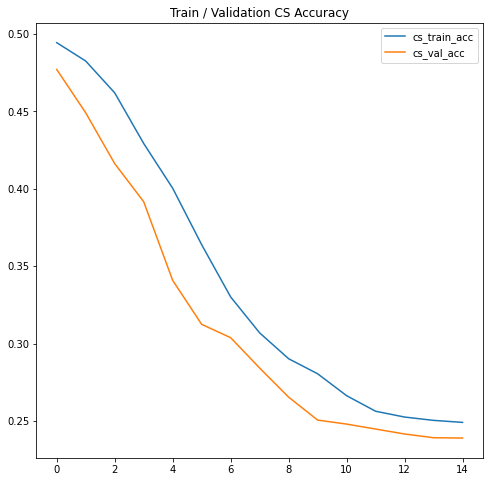

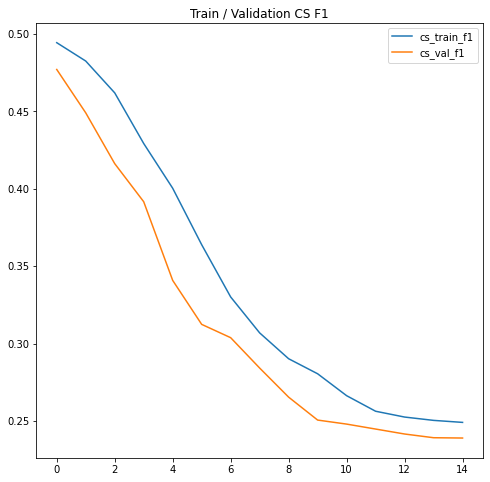

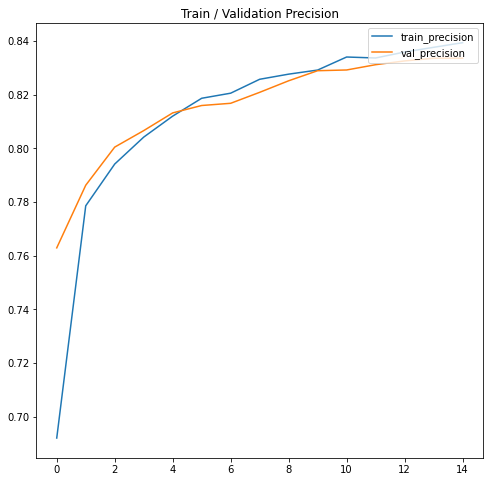

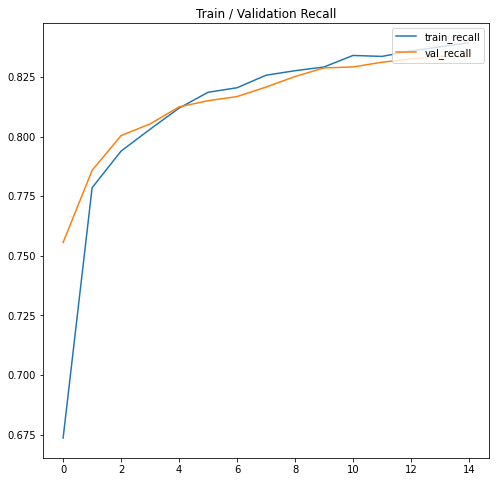

In [14]:
train_wrapper(device_id=1, train_base=False, train_space=True, experiment_name='dense', n_latent=250, config={
    'l1': 0.001,
    'l2': 1e-7,
    'ce_w': 1.0,
    'model_name': 'FacebookAI/roberta-base',
    'dataset_name': 'imdb',
    'prepare_dataset': prepare_dataset,
    'num_labels': 2,
})()

Starting...
Config: {'experiment_name': 'dense', 'log_terminal': True, 'device_id': 1, 'train_base': False, 'train_space': True, 'seed': 42, 'dataset_name': 'imdb', 'model_name': 'FacebookAI/roberta-base', 'num_labels': 2, 'num_epochs': 15, 'iterations': 1, 'max_seq_len': 512, 'batch_size': 256, 'lr': 2e-05, 'fp16': False, 'max_grad_norm': 1000, 'weight_decay': 0.01, 'num_warmup_steps': 0, 'gradient_accumulation_steps': 1, 'n_latent': 300, 'l1': 0.001, 'l2': 1e-07, 'cross_entropy_weight': 1.0, 'preds_from_logits_func': <function get_preds_from_logits at 0x71eb97498a60>, 'get_data_func': <function prepare_dataset at 0x71eb97498670>, 'init_space_func': <function init_space at 0x71eb97497040>, 'init_base_func': <function init_base at 0x71eb974a1b80>}
Loading dataset...
Training space model...
Some weights of RobertaModel were not initialized from the model checkpoint at FacebookAI/roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You shou

Initial GPU Usage
GPU memory occupied: 11831 MB.
GPU Usage after emptying the cache
GPU memory occupied: 1457 MB.


Evaluating space model on test set:
100%|███████████████████████████████████████████| 98/98 [04:07<00:00,  2.52s/it]
Val loss: 0.4830954780383986
Val acc: 0.83816
CS Val acc: 0.5
Val f1: 0.83815994924696
CS Val f1: 0.3333333333333333
Val precision: 0.8381604241884361
Val recall: 0.83816


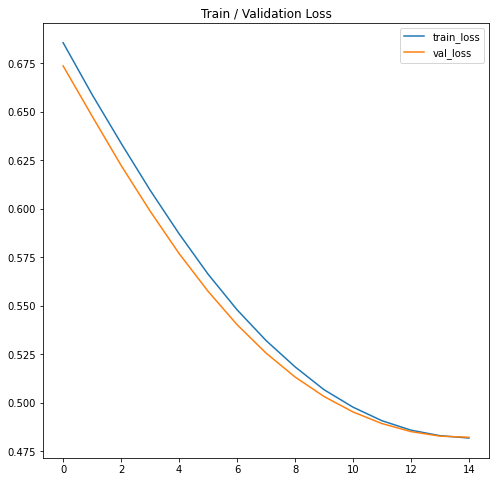

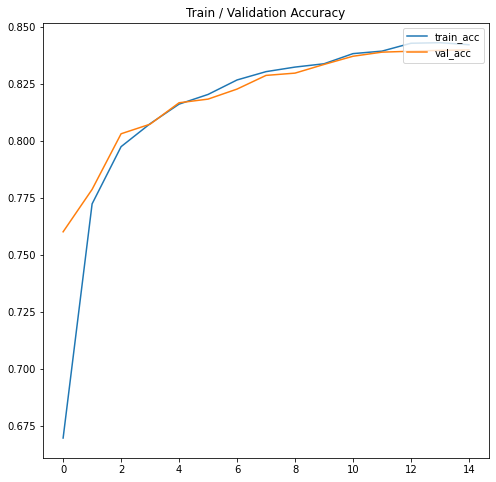

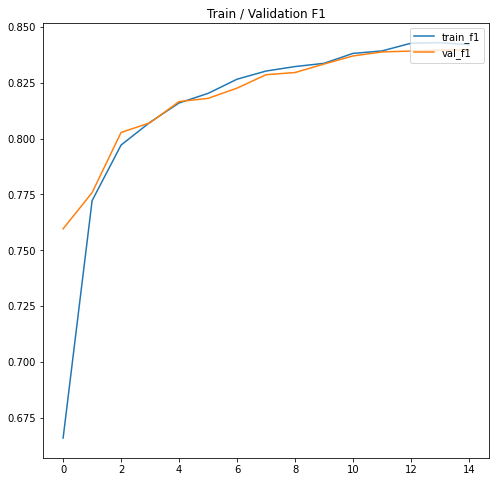

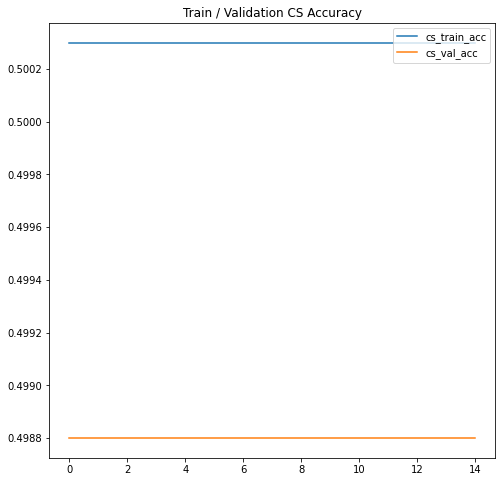

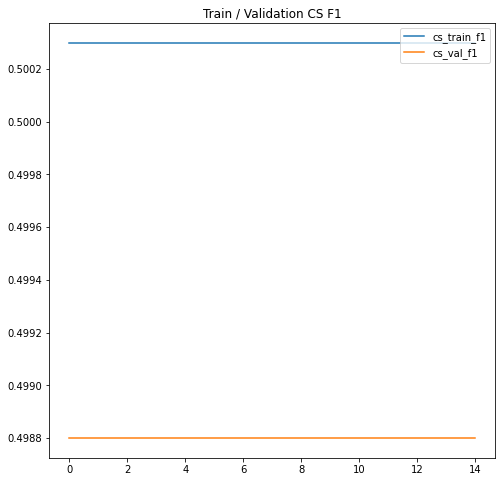

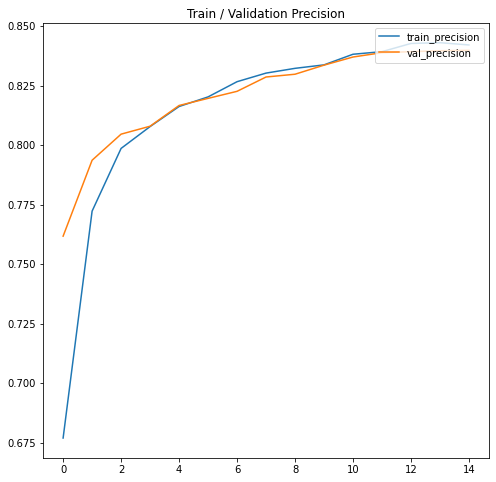

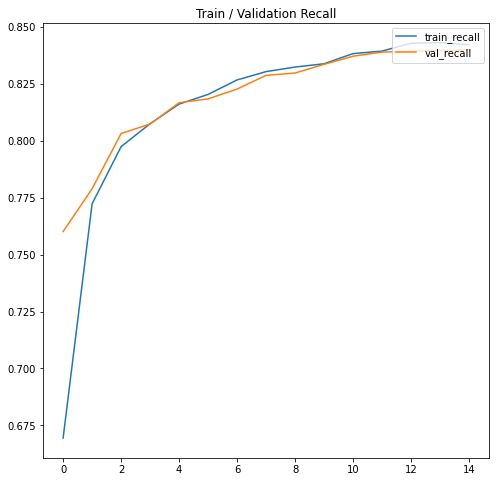

In [15]:
train_wrapper(device_id=1, train_base=False, train_space=True, experiment_name='dense', n_latent=300, config={
    'l1': 0.001,
    'l2': 1e-7,
    'ce_w': 1.0,
    'model_name': 'FacebookAI/roberta-base',
    'dataset_name': 'imdb',
    'prepare_dataset': prepare_dataset,
    'num_labels': 2,
})()